In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
from thop import profile
import numpy as np
from models import *
import cv2
import torch
import torch.optim
from pytorch_msssim import ssim
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *
import torch
import lpips
lpips_vgg_model = lpips.LPIPS(net="vgg")
lpips_alex_model = lpips.LPIPS(net="alex")

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

total_img_ssim=[]
total_img_psnr=[]
total_img_noise_psnr=[]
total_img_lpips_vgg=[]
total_img_lpips_alex=[]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising

fname = '/root/autodl-tmp/INCODE-main/data/denoise_image/0001.png'
print(fname)
im = plt.imread(fname).astype(np.float32)*255
im = cv2.resize(im, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
# img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_pil =im
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

# if PLOT:
#     plot_image_grid([img_np, img_noisy_np], 4, 6);
    
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./25. # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 2001
input_depth = 64
figsize = 4 

H,W=img_pil.shape[0], img_pil.shape[1]
net = get_net(input_depth, 'skip', pad,
                skip_n33d=192, 
                skip_n33u=192, 
                skip_n11=4, 
                num_scales=5,
                upsample_mode='bilinear').type(dtype)
net_input = get_noise(input_depth, INPUT, (img_pil.shape[0], img_pil.shape[1]), var=1./0.5).type(dtype).detach()
print(img_pil.shape[0], img_pil.shape[1])
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()])/1e6; 
print ('Number of params (M): %f' % s)

import torch
from thop import profile

flops, params = profile(net, (net_input,))
print('flops(G): ', flops/1e9, 'params(M): ', params/1e6)


/root/autodl-tmp/INCODE-main/data/denoise_image/0001.png
321 481
Number of params (M): 4.991783
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
flops(G):  104.46627344 params(M):  4.991783


----------------------------------


/root/autodl-tmp/INCODE-main/data/fbc_result/test_dtat/0786.png
339 510
Number of params: 4991783
Starting optimization with ADAM


  0%|          | 0/3001 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


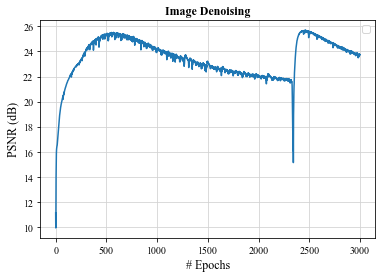

Max PSNR: 25.69107806701823
Max noise PSNR: 25.309876268587544
SSIM: tensor([0.7453])
VGG: LPIPS distance: 0.2906728684902191
ALEX: LPIPS distance: 0.16209134459495544
----------------------------------




In [3]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
# folder_path = '/root/autodl-tmp/INCODE-main/data/denoise_image'
folder_path = '/root/autodl-tmp/INCODE-main/data/fbc_result/test_dtat'
# 遍历文件夹
for filename in os.listdir(folder_path):
    # 检查文件是否为图片
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # 打印图片的完整路径
        print('----------------------------------\n\n')
        fname = str(os.path.join(folder_path, filename))
        print(fname)
        im = plt.imread(fname).astype(np.float32)*255
        im = cv2.resize(im, None, fx=1/4, fy=1/4, interpolation=cv2.INTER_AREA)
        # img_pil = crop_image(get_image(fname, imsize)[0], d=32)
        img_pil =im
        img_np = pil_to_np(img_pil)

        img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

        # if PLOT:
        #     plot_image_grid([img_np, img_noisy_np], 4, 6);
            
        INPUT = 'noise' # 'meshgrid'
        pad = 'reflection'
        OPT_OVER = 'net' # 'net,input'

        reg_noise_std = 1./10. # set to 1./20. for sigma=50
        LR = 0.0015

        OPTIMIZER='adam' # 'LBFGS'
        show_every = 100
        exp_weight=0.99

        num_iter = 3001
        input_depth = 64
        figsize = 4 


        net = get_net(input_depth, 'skip', pad,
                        skip_n33d=192, 
                        skip_n33u=192, 
                        skip_n11=4, 
                        num_scales=5,
                        upsample_mode='bilinear').type(dtype)
        net_input = get_noise(input_depth, INPUT, (img_pil.shape[0], img_pil.shape[1]), var=1./0.5).type(dtype).detach()
        print(img_pil.shape[0], img_pil.shape[1])
        # Compute number of parameters
        s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
        print ('Number of params: %d' % s)

        # Loss
        mse = torch.nn.MSELoss().type(dtype)

        img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
        img_gt_torch = np_to_torch(img_np).type(dtype)
        net_input_saved = net_input.detach().clone()
        noise = net_input.detach().clone()
        out_avg = None
        last_net = None
        psrn_noisy_last = 0

        i = 0
        truth_psnr = []
        noise_psnr = []
        cumulative_times = []
        best_img = None  # 在全局范围内声明best_img
        start_time = time.time()

        def closure():
            global i, out_avg, psrn_noisy_last, last_net, net_input, best_img, truth_psnr
            
            if reg_noise_std > 0:
                net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            out = net(net_input)
            
            # Smoothing
            if out_avg is None:
                out_avg = out.detach()
            else:
                out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
                    
            total_loss = mse(out, img_noisy_torch)
            total_loss.backward()
            
            psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
            psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
            psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
            truth_psnr.append(psrn_gt)
            noise_psnr.append(psrn_noisy)
            
            print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
            
            # 如果当前PSNR比之前的最佳PSNR更高，则更新best_img
            if best_img is None or psrn_gt > max(truth_psnr[:-1]):  # -1 to exclude the current psnr_gt just appended
                best_img = torch_to_np(out).copy()
            
            current_total_time = time.time() - start_time
            cumulative_times.append(current_total_time)
            i += 1

            return total_loss

        p = get_params(OPT_OVER, net, net_input)
        optimize(OPTIMIZER, p, closure, LR, num_iter)

        # out_np = torch_to_np(net(net_input))
        out_np = best_img
        # q = plot_image_grid([np.clip(out_np, 0, 1), img_np,img_noisy_np], factor=13);
        font = {'font': 'Times New Roman', 'size': 12}

        plt.figure()
        axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
        plt.rc('font', **axfont)

        plt.plot(np.arange(len(truth_psnr[:-1])),   truth_psnr[:-1])
        plt.xlabel('# Epochs', fontdict=font)
        plt.ylabel('PSNR (dB)', fontdict=font)
        plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
        plt.legend()
        plt.grid(True, color='lightgray')
        plt.show()


        img_np=torch.tensor(img_np).clone().detach()
        out_np=torch.tensor(out_np).clone().detach()
        vgg_distance = lpips_vgg_model(img_np, out_np)
        alex_distance = lpips_alex_model(img_np, out_np)
      

        ssim_np =ssim(torch.unsqueeze(img_np,dim=0),torch.unsqueeze(out_np,dim=0), data_range=1, size_average=False)
        print('Max PSNR:',np.array(truth_psnr[:-1]).max())
        print('Max noise PSNR:',np.array(noise_psnr[:-1]).max())
        print('SSIM:',ssim_np)
        print("VGG: LPIPS distance:", vgg_distance.item())
        print("ALEX: LPIPS distance:", alex_distance.item())
        print('----------------------------------\n\n')

        total_img_psnr.append(np.array(truth_psnr[:-1]).max())
        total_img_noise_psnr.append(np.array(noise_psnr[:-1]).max())
        total_img_ssim.append(ssim_np.item())
        total_img_lpips_vgg.append(vgg_distance.item())
        total_img_lpips_alex.append(alex_distance.item())
        best_img_save_np = best_img.transpose(1, 2, 0)
        noise_img_np =img_noisy_np.transpose(1, 2, 0)
        origin_img_np =img_np.permute(1,2,0).detach().cpu().numpy()
        best_img_save_name='/root/autodl-tmp/INCODE-main/data/fbc_result/'+'best_'+filename
        noise_img_save_name='/root/autodl-tmp/INCODE-main/data/fbc_result/'+'noise_img_'+filename
        origin_img_save_name='/root/autodl-tmp/INCODE-main/data/fbc_result/'+'origin_img_'+filename
        cv2.imwrite(best_img_save_name,best_img_save_np[:,:,::-1]*255)
        cv2.imwrite(noise_img_save_name,noise_img_np[:,:, ::-1]*255)
        cv2.imwrite(origin_img_save_name,origin_img_np[:,:, ::-1]*255)

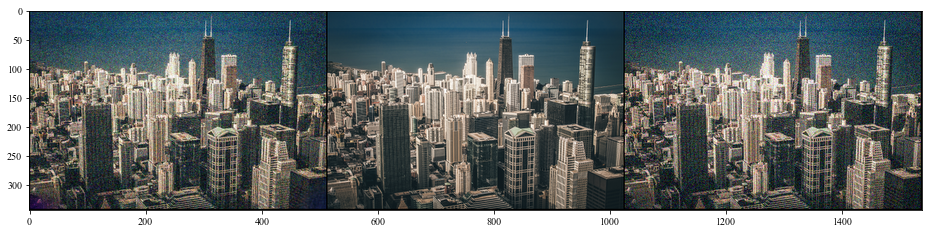

In [7]:
out_np = torch_to_np(net(net_input))
plot_image_grid([np.clip(out_np, 0, 1), img_np.detach().cpu().numpy(),img_noisy_np], factor=13);

In [8]:
total_img_ssim=np.array(total_img_ssim)
total_img_psnr=np.array(total_img_psnr)
total_img_lpips_vgg=np.array(total_img_lpips_vgg)
total_img_lpips_alex=np.array(total_img_lpips_alex)


print('total_img_ssim',total_img_ssim)
print('total_img_psnr',total_img_psnr)
print('total_img_lpips_vgg',total_img_lpips_vgg)
print('total_img_lpips_alex',total_img_lpips_alex)




print('total_img_ssim_mean',total_img_ssim.mean())
print('total_img_psnr_mean',total_img_psnr.mean())
print('total_img_lpips_vgg_mean',total_img_lpips_vgg.mean())
print('total_img_lpips_alex_mean',total_img_lpips_alex.mean())

print('----------------------------------\n\n')

total_img_ssim [0.82433724]
total_img_psnr [27.47514071]
total_img_lpips_vgg [0.23118529]
total_img_lpips_alex [0.09280243]
total_img_ssim_mean 0.8243372440338135
total_img_psnr_mean 27.47514071347506
total_img_lpips_vgg_mean 0.23118528723716736
total_img_lpips_alex_mean 0.09280242770910263
----------------------------------


